In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import statsmodels.api as sm

from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [74]:
data = pd.read_excel('../../data/market_data.xlsx')

In [75]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63457 entries, 0 to 63456
Data columns (total 13 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Time (UTC+10)                                           63457 non-null  datetime64[ns]
 1   Regions NSW Trading Price ($/MWh)                       63457 non-null  float64       
 2   Regions SA Trading Price ($/MWh)                        63457 non-null  float64       
 3   Regions TAS Trading Price ($/MWh)                       63457 non-null  float64       
 4   Regions VIC Trading Price ($/MWh)                       63457 non-null  float64       
 5   Regions NSW Trading Total Intermittent Generation (MW)  63457 non-null  float64       
 6   Regions SA Trading Total Intermittent Generation (MW)   63457 non-null  float64       
 7   Regions TAS Trading Total Intermittent Generation (MW)  63

In [76]:
training = data.loc[(data['Time (UTC+10)'] >= '2018-01-01') &
                            (data['Time (UTC+10)'] < '2021-01-01')]

testing = data.loc[(data['Time (UTC+10)'] >= '2021-01-01')]

In [77]:
training_vic = training[['Time (UTC+10)', 
                         'Regions VIC Trading Price ($/MWh)',
                         'Regions VIC Trading Total Intermittent Generation (MW)',
                         'Regions VIC Operational Demand (MW)']]

testing_vic = testing[['Time (UTC+10)', 
                         'Regions VIC Trading Price ($/MWh)',
                         'Regions VIC Trading Total Intermittent Generation (MW)',
                         'Regions VIC Operational Demand (MW)']]


training_tas = training[['Time (UTC+10)', 
                         'Regions TAS Trading Price ($/MWh)',
                         'Regions TAS Trading Total Intermittent Generation (MW)',
                         'Regions TAS Operational Demand (MW)']]

training_sa = training[['Time (UTC+10)', 
                         'Regions SA Trading Price ($/MWh)',
                         'Regions SA Trading Total Intermittent Generation (MW)',
                         'Regions SA Operational Demand (MW)']]

training_nsw = training[['Time (UTC+10)', 
                         'Regions NSW Trading Price ($/MWh)',
                         'Regions NSW Trading Total Intermittent Generation (MW)',
                         'Regions NSW Operational Demand (MW)']]

In [78]:
def plot_series(x, y, title, xlabel, ylabel):
    plt.plot(x, y)
    plt.title(title, fontsize = 16)
    plt.xticks(['2018-01-01 00:00:00','2019-01-01 00:00:00', '2020-01-01 00:00:00'], ['2018','2019','2020'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for year in range(2018, 2021):
        plt.axvline(datetime.datetime(year,1,1), linestyle = '--', color = 'k', alpha = 0.5)

    plt.show()

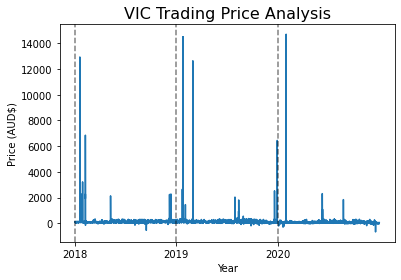

In [79]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Price ($/MWh)'],
            'VIC Trading Price Analysis', 
            'Year',
            'Price (AUD$)')

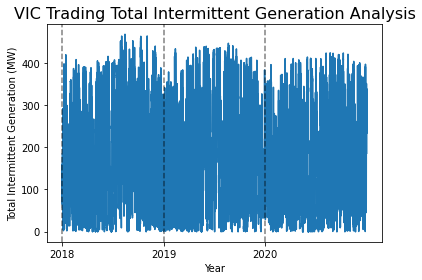

In [80]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Total Intermittent Generation (MW)'],
            'VIC Trading Total Intermittent Generation Analysis', 
            'Year',
            'Total Intermittent Generation (MW)')

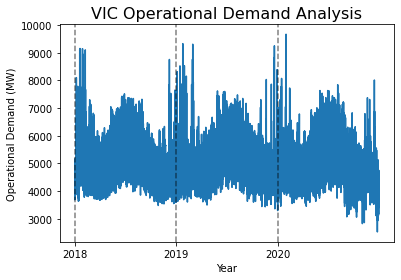

In [81]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Operational Demand (MW)'],
            'VIC Operational Demand Analysis', 
            'Year',
            'Operational Demand (MW)')

### NORMALIZE

In [82]:
def normalize(series):
    mean = series.mean()
    std_dev = series.std()
    result = (series - mean) / std_dev
    return result

In [83]:
# Normalize all data
for column in training_vic.columns:
    if (column != 'Time (UTC+10)'):
        training_vic[column] = normalize(training_vic[column])

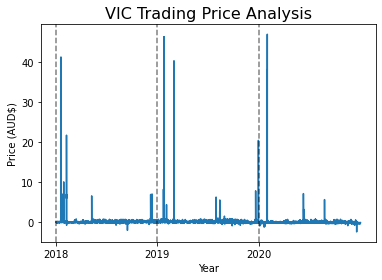

In [84]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Price ($/MWh)'],
            'VIC Trading Price Analysis', 
            'Year',
            'Price (AUD$)')

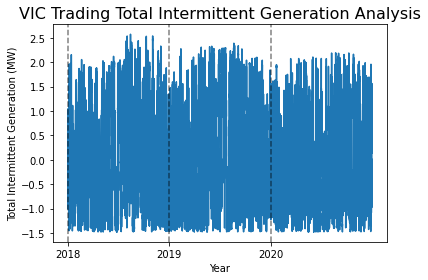

In [85]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Total Intermittent Generation (MW)'],
            'VIC Trading Total Intermittent Generation Analysis', 
            'Year',
            'Total Intermittent Generation (MW)')

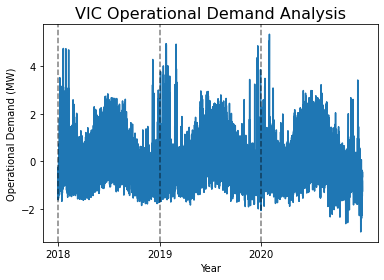

In [86]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Operational Demand (MW)'],
            'VIC Operational Demand Analysis', 
            'Year',
            'Operational Demand (MW)')

### REMOVE SEASONALITY 

In [87]:
training_vic = training_vic.set_index('Time (UTC+10)')
testing_vic = testing_vic.set_index('Time (UTC+10)')

In [88]:
def remove_seasonality(df, series):
    month_avg = df[series].groupby(df[series].index.month).mean()
    month_avg_series = df[series].index.map(lambda x: month_avg.loc[x.month])
    result = df[series] - month_avg_series
    return result

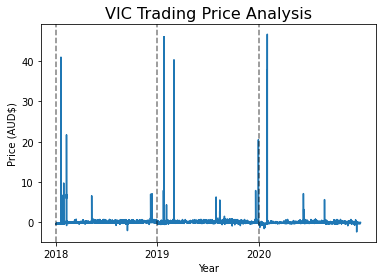

In [89]:
# VIC Trading Price
series = 'Regions VIC Trading Price ($/MWh)'
training_vic[series] = remove_seasonality(training_vic, series)

plot_series(training_vic.index, 
            training_vic['Regions VIC Trading Price ($/MWh)'],
            'VIC Trading Price Analysis', 
            'Year',
            'Price (AUD$)')

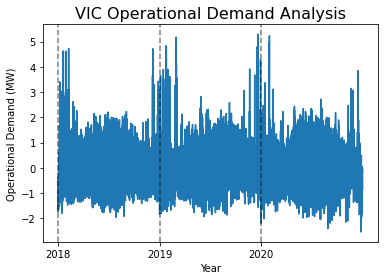

In [90]:
# VIC Operational Demand
series = 'Regions VIC Operational Demand (MW)'
training_vic[series] = remove_seasonality(training_vic, series)

plot_series(training_vic.index, 
            training_vic['Regions VIC Operational Demand (MW)'],
            'VIC Operational Demand Analysis', 
            'Year',
            'Operational Demand (MW)')

### Partial Autocorrelation Funciton (PACF) on VIC Trading Price

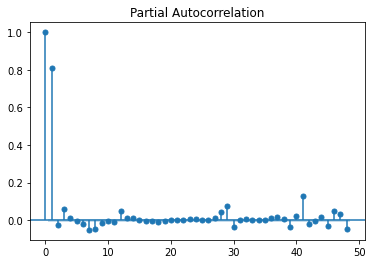

In [91]:
sm.graphics.tsa.plot_pacf(training_vic['Regions VIC Trading Price ($/MWh)'])
plt.show()

Observe that PACF declines at Lag 1

### Correlation between VIC Trading Price and VIC Trading Total Intermittent Generation

In [92]:
for lag in range(1, 25):
    lag_TP_vic = training_vic['Regions VIC Trading Price ($/MWh)'].iloc[lag:]
    lag_TIG_vic = training_vic['Regions VIC Trading Total Intermittent Generation (MW)'].iloc[:-lag]
    print("Lag:" + str(lag))
    print(pearsonr(lag_TP_vic, lag_TIG_vic))
    print("\n")

Lag:1
(-0.05429416337284791, 1.2043182874643505e-35)


Lag:2
(-0.0517936234951885, 1.38151868560471e-32)


Lag:3
(-0.049188957883930615, 1.4967608022073983e-29)


Lag:4
(-0.04700495099277945, 3.984449249850771e-27)


Lag:5
(-0.044348016831300574, 2.534285085365038e-24)


Lag:6
(-0.041622473299554444, 1.2959853767846614e-21)


Lag:7
(-0.03857118438039925, 8.803191610909747e-19)


Lag:8
(-0.035453775166156304, 4.1680510050449416e-16)


Lag:9
(-0.03283177275231073, 5.01050208894639e-14)


Lag:10
(-0.029984699700107878, 6.063475156795081e-12)


Lag:11
(-0.0271393006335987, 4.811399115686543e-10)


Lag:12
(-0.024181175572347197, 2.9170152925985392e-08)


Lag:13
(-0.021704418194514574, 6.422061617731694e-07)


Lag:14
(-0.019550812339162678, 7.326201967271313e-06)


Lag:15
(-0.01809159765975514, 3.3361494893130465e-05)


Lag:16
(-0.016301081385029063, 0.00018513793580214632)


Lag:17
(-0.014822381884720508, 0.000675629161875701)


Lag:18
(-0.013534467809577105, 0.0019101271467255924)


Lag:19

### Correlation between VIC Trading Price and VIC Operational Demand

In [93]:
for lag in range(1, 25):
    lag_TP_vic = training_vic['Regions VIC Trading Price ($/MWh)'].iloc[lag:]
    lag_TIG_vic = training_vic['Regions VIC Operational Demand (MW)'].iloc[:-lag]
    print("Lag:" + str(lag))
    print(pearsonr(lag_TP_vic, lag_TIG_vic))
    print("\n")

Lag:1
(0.21373007683444767, 0.0)


Lag:2
(0.2039169748649176, 0.0)


Lag:3
(0.19259954393683099, 0.0)


Lag:4
(0.1803964866343991, 0.0)


Lag:5
(0.16731503951470045, 0.0)


Lag:6
(0.1545045246988737, 2.422983395358749e-278)


Lag:7
(0.1421019607129905, 2.451356456340192e-235)


Lag:8
(0.12971072150727392, 4.242357281933547e-196)


Lag:9
(0.11825019850132562, 4.322871727824203e-163)


Lag:10
(0.10777368360754394, 1.1860507378188291e-135)


Lag:11
(0.09812467103332798, 1.1241879305162192e-112)


Lag:12
(0.08888583871543887, 1.0053003487797083e-92)


Lag:13
(0.08042669046927514, 3.329530137994215e-76)


Lag:14
(0.07295893047717276, 5.304843783642984e-63)


Lag:15
(0.06606124371997224, 5.926018481898426e-52)


Lag:16
(0.05999588773883636, 3.814181880847693e-43)


Lag:17
(0.055046138116026724, 1.3912965453736705e-36)


Lag:18
(0.05052496698432879, 4.43175764715744e-31)


Lag:19
(0.046130050441712256, 3.5330746293774054e-26)


Lag:20
(0.04152131520719067, 1.641230375755318e-21)


Lag:21
(0.0

### Vector Autoregression Model (VAR) 

In [94]:
vic_training = training_vic[['Regions VIC Trading Price ($/MWh)',
                             'Regions VIC Trading Total Intermittent Generation (MW)',
                             'Regions VIC Operational Demand (MW)']]

vic_testing = testing_vic[['Regions VIC Trading Price ($/MWh)',
                             'Regions VIC Trading Total Intermittent Generation (MW)',
                             'Regions VIC Operational Demand (MW)']]

In [95]:
model = VAR(vic_training)
x = model.select_order(maxlags = 24)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.2433,-0.2428,0.7840,-0.2432
1,-8.401,-8.399,0.0002247,-8.400
2,-9.593,-9.589,6.824e-05,-9.591
3,-9.603,-9.598,6.752e-05,-9.601
4,-9.606,-9.600,6.731e-05,-9.604
5,-9.615,-9.607,6.672e-05,-9.612
6,-9.617,-9.608,6.658e-05,-9.614
7,-9.620,-9.609,6.635e-05,-9.617
8,-9.623,-9.611,6.617e-05,-9.619
9,-9.624,-9.610,6.611e-05,-9.620


In [96]:
model = VAR(vic_training)
model = model.fit(maxlags = 20)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Oct, 2021
Time:                     03:53:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.64407
Nobs:                     52588.0    HQIC:                  -9.66529
Log likelihood:           30718.4    FPE:                6.28387e-05
AIC:                     -9.67494    Det(Omega_mle):     6.26205e-05
--------------------------------------------------------------------
Results for equation Regions VIC Trading Price ($/MWh)
                                                                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------------------
const                                                              0.000007         0.002531            

In [97]:
lag = 20

In [98]:
laaged_values = training_vic.values[-lag:]

In [100]:
forecast = pd.DataFrame(model.forecast(y = laaged_values, steps=len(testing_vic.index)), index = testing_vic.index, columns = testing_vic.columns)

In [103]:
forecast.head()

,Regions VIC Trading Price ($/MWh),Regions VIC Trading Total Intermittent Generation (MW),Regions VIC Operational Demand (MW)
Time (UTC+10),,,
2021-01-01 00:00:00,0.036973,0.111385,-0.017565
2021-01-01 00:30:00,0.077280,0.073778,0.114203
2021-01-01 01:00:00,0.093194,0.038863,0.220470
2021-01-01 01:30:00,0.124425,0.016836,0.313056
2021-01-01 02:00:00,0.128219,0.001958,0.377610


In [105]:
price_true = testing_vic['Regions VIC Trading Price ($/MWh)'].to_list()
price_pred = forecast['Regions VIC Trading Price ($/MWh)'].to_list()

In [106]:
mean_squared_error(price_true, price_pred)

22164.505198830044